In [14]:
import pandas as pd
import numpy as np
import scipy.stats as sc

In [208]:
data = pd.read_csv('diabetes.txt', sep = " ")

In [16]:
# This is the good data
data.shape

(442, 11)

In [17]:
# Define X and Y arrays
X = data.iloc[:,:data.shape[1]-1].as_matrix()
Y = data.iloc[:,data.shape[1]-1].ravel()

In [18]:
# We center the Y
Y_tilde = Y - Y.mean(axis=0)

## 1] CHOOSING THE BAYESIAN LASSO PARAMETER

The Gibbs sampler used here uses the following full conditional distributions:

- The full conditional for $\beta$ is:

<h3 align="center"> $\mathcal{N}_p(A^{-1}X^T\tilde{y}, \sigma^2A^{-1})$ where $A = X^TX+D^{-1}_\tau$ and $D_\tau = diag(\tau^2_1,...,\tau^2_p)$ </h3>

- The full conditional for $\sigma^2$ is:

<h3 align="center"> $\mathcal{I}nverse\mathcal{G}amma(\frac{n-1+p}{2}, \frac{(\tilde{y}-X\beta)^T(\tilde{y}-X\beta) + \beta^TD^{-1}_\tau\beta}{2})$ </h3>

- $\tau^2_1, ..., \tau^2_p$ are conditionnaly independent and $\frac{1}{\tau^2_j}$ has as conditional distribution:

<h3 align="center"> $\mathcal{I}nverse\mathcal{G}ausian(\sqrt{\frac{\lambda^2\sigma^2}{\beta^2_j}}, \lambda^2)$ </h3>

In [45]:
def Gibbs_sampler(n, lambda_):
    # Initialization
    beta = [np.random.uniform(size = X.shape[1])]
    sigma_sq = [np.random.uniform()]
    tau_sq = [np.random.uniform(size = X.shape[1])]
    for i in range(n):
        # Full conditional for beta
        D_tau = np.diag(tau_sq[i])
        A = X.transpose().dot(X) + np.linalg.inv(D_tau)
        multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
        multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)
        beta.append(np.random.multivariate_normal(multi_norm_mean, multi_norm_cov))
        # Full conditional for sigma_sq
        shape = (X.shape[0]-1+X.shape[1])/2
        scale = ((Y_tilde - X.dot(beta[i+1])).dot((Y_tilde - X.dot(beta[i+1]))) + beta[i+1].transpose().dot(np.linalg.inv(D_tau)).dot(beta[i+1]))/2
        sigma_sq.append(sc.invgamma.rvs(a = shape, scale = scale))
        # Full conditional for tau_1,...,tau_p
        mean = np.sqrt(lambda_**2*sigma_sq[i+1]/beta[i+1]**2)
        scale = np.repeat(lambda_**2, X.shape[1])
        tau_sq.append(1/np.random.wald(mean, scale))
    return tau_sq[int(n/2):]

#### Empirical Bayes by Marginal Maximum Likelihood

For the Bayesian Lasso, each iteration of the algorithm involves running the Gibbs sampler using a $\lambda$ value estimated from the sample of the previous iteration. Specifically, iteration $k$ uses the Gibbs sampler of Section 2 with hyperparameter $\lambda^{(k-1)}$ (i.e., the estimate from iteration $k-1$) to approximate the ideal updated estimate:

<h3 align="center"> $\lambda^{(k)} = \sqrt{\frac{2p}{\sum\limits^p_{j=1}E_{\lambda^{(k-1)}}[\tau^2_j|\tilde{y}]}}$ </h3>

by replacing the conditional expectations with averages from the Gibbs sample. We suggest the initial value:

<h3 align="center"> $\lambda^{(0)} = \frac{p\sqrt{\hat{\sigma}^2_{LS}}}{\sum\limits^p_{j=1}|\hat{\beta}^{LS}_j|}$ </h3>

where $\hat{\sigma}^2_{LS}$ and $\hat{\beta}^{LS}_j$ are estimates from the usual least squares procedure.

In [46]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,Y_tilde)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
# Lambda_init
lambda_init = (X.shape[1]*np.sqrt((np.sum((Y_tilde - lm.predict(X))**2))/(X.shape[0]-X.shape[1])))/np.sum(np.abs(lm.coef_))

In [48]:
# This will be used to find the next k lambda
for i in range(30):
    if i==0:
        lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(1000, lambda_init), axis=0)))
    else:
        lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(1000, lambda_), axis=0)))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [49]:
lambda_

0.23061302724653052

#### Hyperpriors for the Lasso Parameter

We need to modify the previous Gibbs sampler by introducing the full conditional distribution of $\lambda^2$, which is:

<h3 align="center"> $\mathcal{G}amma(p+r, \frac{\sum\limits_{j=1}^p\tau^2_j}{2}+\delta)$ </h3>

In [3]:
def Gibbs_sampler_bis(n, r, delta):
    # Initialization
    beta = [np.random.uniform(size = X.shape[1])]
    sigma_sq = [np.random.uniform()]
    tau_sq = [np.random.uniform(size = X.shape[1])]
    lambda_sq = [np.random.uniform()]
    for i in range(n):
        # Full conditional for beta
        D_tau = np.diag(tau_sq[i])
        A = X.transpose().dot(X) + np.linalg.inv(D_tau)
        multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
        multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)
        beta.append(np.random.multivariate_normal(multi_norm_mean, multi_norm_cov))
        # Full conditional for sigma_sq
        shape = (X.shape[0]-1+X.shape[1])/2
        scale = ((Y_tilde - X.dot(beta[i+1])).dot((Y_tilde - X.dot(beta[i+1]))) + beta[i+1].transpose().dot(np.linalg.inv(D_tau)).dot(beta[i+1]))/2
        sigma_sq.append(sc.invgamma.rvs(a = shape, scale = scale))
        # Full conditional for tau_1,...,tau_p
        mean = np.sqrt(lambda_sq[i]*sigma_sq[i+1]/beta[i+1]**2)
        scale = np.repeat(lambda_sq[i], X.shape[1])
        tau_sq.append(1/np.random.wald(mean, scale))
        # Full conditional for lambda_sq
        shape = X.shape[1] + r
        rate = sum(tau_sq[i+1])/2+delta
        lambda_sq.append(np.random.gamma(shape, 1/rate))
    return lambda_sq

In [12]:
lambda_sq_bis = Gibbs_sampler_bis(10000, 1, 1.78)

In [13]:
np.median([np.sqrt(i) for i in lambda_sq_bis])

0.27732732052639703

## 2] Graph of the paper

#### Compute Bayesian lasso coefficients with corresponding lambda_ (selected according to marginal maximum likelihood)

In [100]:
def test(n, lambda_):
    # Initialization
    beta = [np.random.uniform(size = X.shape[1])]
    sigma_sq = [np.random.uniform()]
    tau_sq = [np.random.uniform(size = X.shape[1])]
    for i in range(n):
        # Full conditional for beta
        D_tau = np.diag(tau_sq[i])
        A = X.transpose().dot(X) + np.linalg.inv(D_tau)
        multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
        multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)
        beta.append(np.random.multivariate_normal(multi_norm_mean, multi_norm_cov))
        # Full conditional for sigma_sq
        shape = (X.shape[0]-1+X.shape[1])/2
        scale = ((Y_tilde - X.dot(beta[i+1])).dot((Y_tilde - X.dot(beta[i+1]))) + beta[i+1].transpose().dot(np.linalg.inv(D_tau)).dot(beta[i+1]))/2
        sigma_sq.append(sc.invgamma.rvs(a = shape, scale = scale))
        # Full conditional for tau_1,...,tau_p
        mean = np.sqrt(lambda_**2*sigma_sq[i+1]/beta[i+1]**2)
        scale = np.repeat(lambda_**2, X.shape[1])
        tau_sq.append(1/np.random.wald(mean, scale))
    return beta[int(n/2):]

In [251]:
bayesian_lasso_coef_ml = np.median(test(100000, lambda_), axis=0)

#### Compute Bayesian lasso coefficients with corresponding lambda_ (Hyperpriors for the Lasso Parameter)

In [245]:
def test_bis(n, r, delta):
    # Initialization
    beta = [np.random.uniform(size = X.shape[1])]
    sigma_sq = [np.random.uniform()]
    tau_sq = [np.random.uniform(size = X.shape[1])]
    lambda_sq = [np.random.uniform()]
    for i in range(n):
        # Full conditional for beta
        D_tau = np.diag(tau_sq[i])
        A = X.transpose().dot(X) + np.linalg.inv(D_tau)
        multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
        multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)
        beta.append(np.random.multivariate_normal(multi_norm_mean, multi_norm_cov))
        # Full conditional for sigma_sq
        shape = (X.shape[0]-1+X.shape[1])/2
        scale = ((Y_tilde - X.dot(beta[i+1])).dot((Y_tilde - X.dot(beta[i+1]))) + beta[i+1].transpose().dot(np.linalg.inv(D_tau)).dot(beta[i+1]))/2
        sigma_sq.append(sc.invgamma.rvs(a = shape, scale = scale))
        # Full conditional for tau_1,...,tau_p
        mean = np.sqrt(lambda_sq[i]*sigma_sq[i+1]/beta[i+1]**2)
        scale = np.repeat(lambda_sq[i], X.shape[1])
        tau_sq.append(1/np.random.wald(mean, scale))
        # Full conditional for lambda_sq
        shape = X.shape[1] + r
        rate = sum(tau_sq[i+1])/2+delta
        lambda_sq.append(np.random.gamma(shape, 1/rate))
    return beta[int(n/2):]

In [246]:
bayesian_lasso_coef_hyp = np.median(test_bis(10000, 1, 1.78), axis=0)

#### Lasso estimates based on n-fold cross validation

In [200]:
from sklearn import linear_model
lasso = linear_model.LassoCV()
lasso.fit(X, Y_tilde)

# The estimator chose automatically its lambda:
lasso_cv_coef = lasso.coef_

#### Estimates of ordianry least squares

In [170]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,Y_tilde)
least_squares_coef = lm.coef_

#### Graph

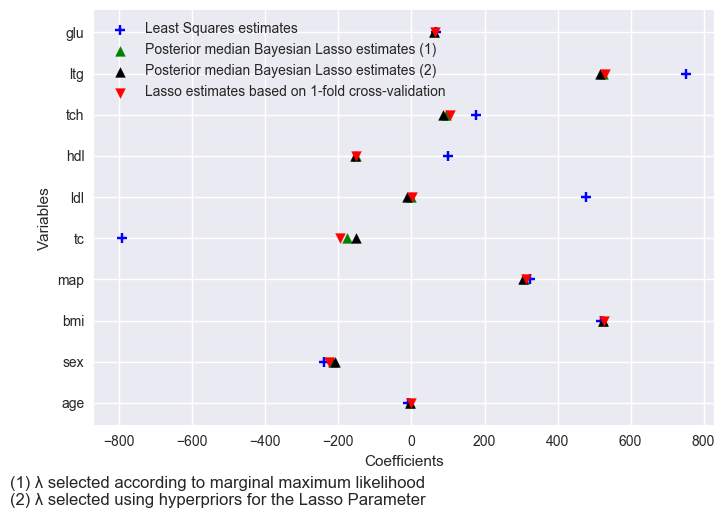

In [259]:
# libraries
import matplotlib.pyplot as plt


df = pd.DataFrame({'variables':list(data.columns[:-1]), 'Least Squares':least_squares_coef, 'Bayesian Lasso ml':bayesian_lasso_coef_ml,'Bayesian Lasso hyp':bayesian_lasso_coef_hyp , 'CV Lasso':lasso_cv_coef})
my_range=range(1,len(df.index)+1)


# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.scatter(df['Least Squares'], my_range, color='blue', alpha=1, label='Least Squares estimates', marker='+')
plt.scatter(df['Bayesian Lasso ml'], my_range, color='green', alpha=1 , label='Posterior median Bayesian Lasso estimates (1)', marker='^')
plt.scatter(df['Bayesian Lasso hyp'], my_range, color='black', alpha=1 , label='Posterior median Bayesian Lasso estimates (2)', marker='^')
plt.scatter(df['CV Lasso'], my_range, color='red', alpha=1 , label='Lasso estimates based on 1-fold cross-validation', marker='v')
plt.legend()

# Add title and axis names
plt.yticks(my_range, df['variables'])
plt.title("", loc='center')
plt.xlabel('Coefficients')
plt.ylabel('Variables')
plt.figtext(.02, -.02, "(1) λ selected according to marginal maximum likelihood\n(2) λ selected using hyperpriors for the Lasso Parameter")


## 3] Test on largest dataset

In [9]:
train = pd.read_table('phy_train.dat', header=None)
train = train.drop([0,80], axis = 1)
train = train.sample(4000)
train.index = [i for i in range(len(train))]

In [10]:
train.shape

(4000, 79)

In [12]:
X = train.iloc[:,1:].as_matrix()
Y_tilde = train.iloc[:,0].ravel()

#### Empirical Bayes by Marginal Maximum Likelihood

#### Problem encountered in large dimension: Theory vs Implementation

We have the problem that $\sigma^2A^{-1}$ which is the covariance matrix used to generate the $\beta$'s is from the computer point of view not positive semi-definite.

Theoretically, the matrix is positive semidefinite, with several eigenvalues being exactly zero. But the computations with floating point numbers introduce truncation errors which result in some of those eigenvalues being very small but negative; hence, the matrix is not positive semidefinite.

A way to correct for the floating point errors is to add a tiny multiple of the identity matrix to the covariance matrix. I take this into account and add it in my Gibbs sampler.

In [24]:
def Gibbs_sampler_corrected(n, lambda_):
    # Initialization
    beta = [np.random.uniform(size = X.shape[1])]
    sigma_sq = [np.random.uniform()]
    tau_sq = [np.random.uniform(size = X.shape[1])]
    for i in range(n):
        # Full conditional for beta
        D_tau = np.diag(tau_sq[i])
        A = X.transpose().dot(X) + np.linalg.inv(D_tau)
        multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
        min_eig = np.min(np.real(np.linalg.inv(A)))
        if min_eig < 0:
            A -= 10*min_eig * np.eye(*A.shape)
        multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)
        beta.append(np.random.multivariate_normal(multi_norm_mean, multi_norm_cov))
        # Full conditional for sigma_sq
        shape = (X.shape[0]-1+X.shape[1])/2
        scale = ((Y_tilde - X.dot(beta[i+1])).dot((Y_tilde - X.dot(beta[i+1]))) + beta[i+1].transpose().dot(np.linalg.inv(D_tau)).dot(beta[i+1]))/2
        sigma_sq.append(sc.invgamma.rvs(a = shape, scale = scale))
        # Full conditional for tau_1,...,tau_p
        mean = np.sqrt(lambda_**2*sigma_sq[i+1]/beta[i+1]**2)
        scale = np.repeat(lambda_**2, X.shape[1])
        tau_sq.append(1/np.random.wald(mean, scale))
    return tau_sq[int(n/2):]

In [108]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
lm = LinearRegression()
lm.fit(X,Y_tilde)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [109]:
# Lambda_init
lambda_init = (X.shape[1]*np.sqrt((np.sum((Y_tilde - lm.predict(X))**2))/(X.shape[0]-X.shape[1])))/np.sum(np.abs(lm.coef_))

In [110]:
# This will be used to find the next k lambda
for i in range(30):
    if i==0:
        lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler_corrected(500, lambda_init), axis=0)))
    else:
        lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler_corrected(500, lambda_), axis=0)))
    print(lambda_)

5.26665805355
5.59305097913
5.91124696831
6.20457412871
6.51184497099
6.72523038935
6.94110669825
7.12960566031
7.27643243202
7.3649458038
7.5547944618
7.65335808623
7.77826534302
7.89471461942
7.94030717377
8.00715083883
8.04480411059
8.04508612004
8.10080347518
8.1995552176
8.19078450531
8.23363472765
8.26019279299
8.27042880624
8.28150675074
8.29519869812
8.29114803958
8.28164779756
8.27637677628
8.28530037741


In [111]:
lambda_

8.2853003774086513

#### Hyperpriors for the Lasso Parameter

Same problem as before, so I need to modify the Gibbs sampler

In [112]:
def Gibbs_sampler_bis_corrected(n, r, delta):
    # Initialization
    beta = [np.random.uniform(size = X.shape[1])]
    sigma_sq = [np.random.uniform()]
    tau_sq = [np.random.uniform(size = X.shape[1])]
    lambda_sq = [np.random.uniform()]
    for i in range(n):
        # Full conditional for beta
        D_tau = np.diag(tau_sq[i])
        A = X.transpose().dot(X) + np.linalg.inv(D_tau)
        multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
        #min_eig = np.min(np.real(np.linalg.inv(A)))
        #if min_eig < 0:
        #    A -= 10*min_eig * np.eye(*A.shape)
        multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)
        beta.append(np.random.multivariate_normal(multi_norm_mean, multi_norm_cov))
        # Full conditional for sigma_sq
        shape = (X.shape[0]-1+X.shape[1])/2
        scale = ((Y_tilde - X.dot(beta[i+1])).dot((Y_tilde - X.dot(beta[i+1]))) + beta[i+1].transpose().dot(np.linalg.inv(D_tau)).dot(beta[i+1]))/2
        sigma_sq.append(sc.invgamma.rvs(a = shape, scale = scale))
        # Full conditional for tau_1,...,tau_p
        mean = np.sqrt(lambda_sq[i]*sigma_sq[i+1]/beta[i+1]**2)
        scale = np.repeat(lambda_sq[i], X.shape[1])
        tau_sq.append(1/np.random.wald(mean, scale))
        # Full conditional for lambda_sq
        shape = X.shape[1] + r
        rate = sum(tau_sq[i+1])/2+delta
        lambda_sq.append(np.random.gamma(shape, 1/rate))
    return lambda_sq[int(n/2):]

In [113]:
lambda_sq_bis = Gibbs_sampler_bis_corrected(500, 2.1, 0.03)

In [114]:
np.median([np.sqrt(i) for i in lambda_sq_bis])

8.3610682703379222

We can choose the parameters $r$ and $\delta$ so that the penalty terms chosen by the two methods match. But theoretically, how to choose these 2 parameters for the second method?

## Which Lasso parameter is the best empirically? (Which one is chosen by cross validation)